In [1]:
%load_ext autoreload
%autoreload 2

The MLE (MAP) best-fit only gives you a point estimate, what if you want to get a distribution over the parameter space? That's when Markov Chain Monte Carlo (MCMC) come into play. Currently, you can use [$\mathit{emcee}$](https://emcee.readthedocs.io/en/stable/) to run MCMC on the __EzTao__ CARMA kernels. Future versions of __EzTao__, upon migration to the $\mathit{celerite2}$ backend, the support for other popular probabilistic inference library like $\mathit{PyMC}$ will be added. 

### 1. MCMC on CARMA models lower than/equal to CARMA(2,1)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import eztao
from eztao.carma import DRW_term
from eztao.ts import gpSimRand
from eztao.ts import drw_fit
from celerite import GP
import emcee
import corner

mpl.rc_file(os.path.join(eztao.__path__[0], "viz/eztao.rc"))

#### 1.1 Simulate & Get MLE best-fit

In [3]:
# initialize a DRW model
amp = 0.3
tau = 100
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

# simulate a process using the above model
t, y, yerr = gpSimRand(DRW_kernel, 10, 365*10, 200)

In [4]:
# obtain best-fit as intial position for MCMC
best_fit_drw = drw_fit(t, y, yerr)
print(f'Best-fit DRW parameters:{best_fit_drw}')

Best-fit DRW parameters:[ 0.26456043 84.50775775]


#### 1.2 MCMC

In [5]:
# define log prob function
from eztao.ts import neg_param_ll
def param_ll(*args):
    return -neg_param_ll(*args)

In [6]:
# init GP
drw_kernel_mcmc = DRW_term(*np.log(best_fit_drw))
drw_gp = GP(drw_kernel_mcmc, mean=np.median(y))
drw_gp.compute(t, yerr)

In [7]:
# run MCMC
initial = np.array(np.log(best_fit_drw))
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, param_ll, args=[y, drw_gp])

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


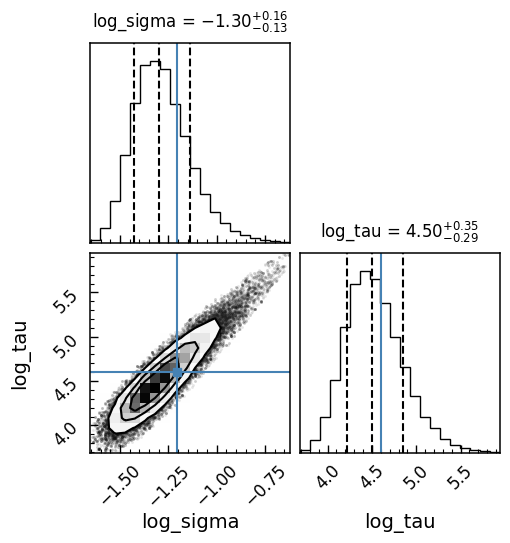

In [8]:
# remove points with low prob for the sake of making good corner plot
prob_threshold = np.percentile(sampler.flatlnprobability, 1)
clean_chain = sampler.flatchain[sampler.flatlnprobability > prob_threshold, :]

# make corner plot
labels = [name.split(':')[1] for name in drw_gp.get_parameter_names()]
corner.corner(clean_chain, truths=DRW_kernel.get_parameter_vector(),
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 12});

### 2. MCMC on CARMA models higher than CARMA(2,1)

In [9]:
from eztao.carma import CARMA_term
from eztao.ts import carma_fit

#### 2.1 Simulate & Get MLE best-fit

In [10]:
# simulate a CARMA(3,0) process
p = 3
q = 0
carma_kernel = CARMA_term(np.log([3, 3.189, 0.05]), np.log([0.5]))
t2, y2, yerr2 = gpSimRand(carma_kernel, 200, 365*10, 2000)

In [11]:
# obtain best-fit as intial position for MCMC
best_fit2 = carma_fit(t2, y2, yerr2, p, q, de=False, mode='coeff', n_iter=20, 
                      user_bounds=[(None, None)]*4)
print(f'Best-fit CARMA(3,0) parameters:{best_fit2}')

/Users/weixiang/Projects/EzTao/env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/weixiang/Projects/EzTao/src/eztao/carma/CARMATerm.py:231: RuntimeWarning: divide by zero encountered in log
  self.set_parameter_vector(np.log(np.append(ARpars, MApars)))


Best-fit CARMA(3,0) parameters:[2.77013145 2.78622679 0.0514474  0.4620867 ]


#### 2.2 MCMC
Extra steps need to be taken when running MCMC with higher order CARMA models as we will sample in the polynomial space instead of the nominal CARMA space. Most importantly, you will need to initialize the MCMC walkers in the polynomial space. __EzTao__ provides the function to convert parameters between two spaces.

In [12]:
# define log prob function
from eztao.ts import neg_fcoeff_ll
def fcoeff_ll(*args):
    params = args[0]
#     print(params)
    if (params > 15).any() or (params < -15).any():
        return -np.inf
    else:
        return -neg_fcoeff_ll(*args)

In [13]:
# get the representation of the best-fit in the polynomial space
best_fcoeffs = carma_kernel.carma2fcoeffs(np.log(best_fit2[:p]), np.log(best_fit2[p:]))
print(f'Best-fit in polynomial space: {best_fcoeffs}')

Best-fit in polynomial space: [2.751317   2.73446227 0.01881445 0.4620867 ]


In [14]:
# init GP
carma_kernel_mcmc = CARMA_term(np.log(best_fit2)[:p], np.log(best_fit2)[p:])
carma_gp = GP(carma_kernel_mcmc, mean=np.median(y2))
carma_gp.compute(t2, yerr2)

In [15]:
# run MCMC
initial = np.log(best_fcoeffs)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, fcoeff_ll, args=[y2, carma_gp])

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


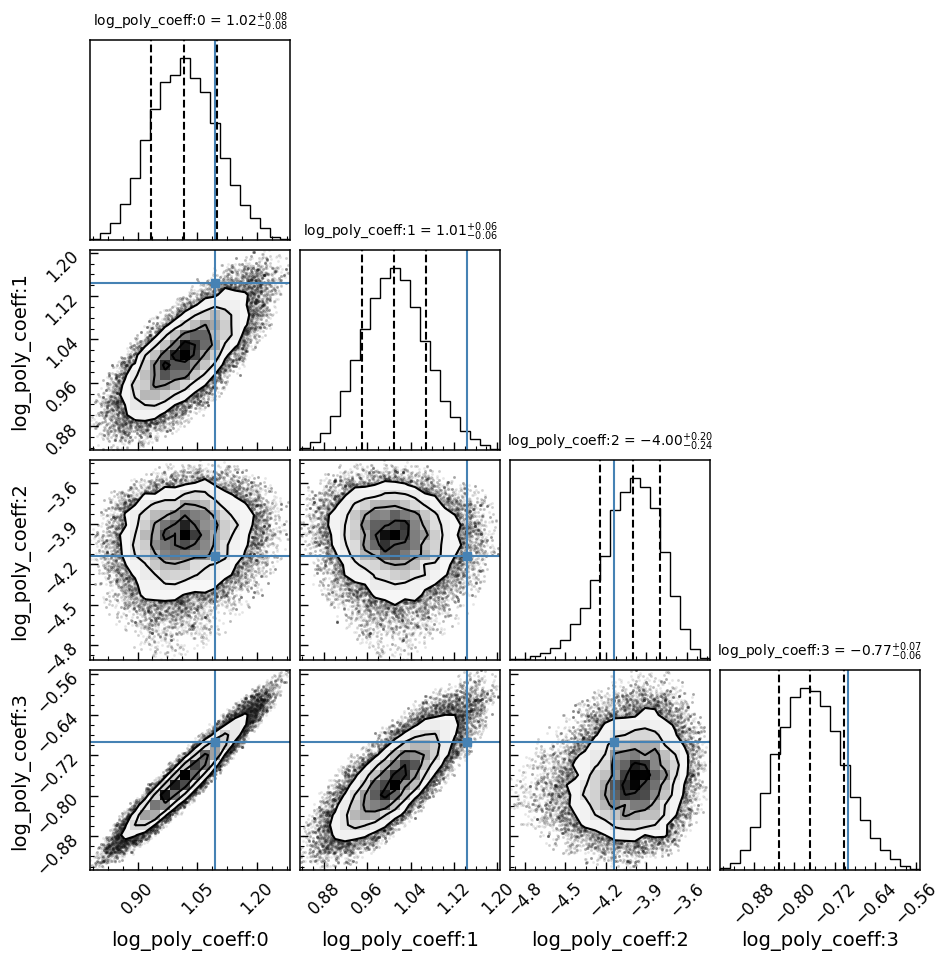

In [16]:
# remove points with low prob for the sake of making good corner plot
prob_threshold = np.percentile(sampler.flatlnprobability, 5)
clean_chain = sampler.flatchain[sampler.flatlnprobability > prob_threshold, :]

# get the poly representation of the input model
true_fcoeffs = carma_kernel.carma2fcoeffs(np.log([3, 3.189, 0.05]), np.log([0.5]))

# make corner plot
labels = [f'log_poly_coeff:{i}' for i in range(4)]
corner.corner(clean_chain, truths=np.log(true_fcoeffs),
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 10});

#### What about in the nominal CARMA space?

In [17]:
flat_chain = sampler.flatchain
total_chain = sampler.flatchain.shape[0]
carma_params = np.zeros((total_chain, ndim))

for i in np.arange(sampler.flatchain.shape[0]):
    carma_params[i] = np.append(*carma_kernel_mcmc.fcoeffs2carma(flat_chain[i], p))

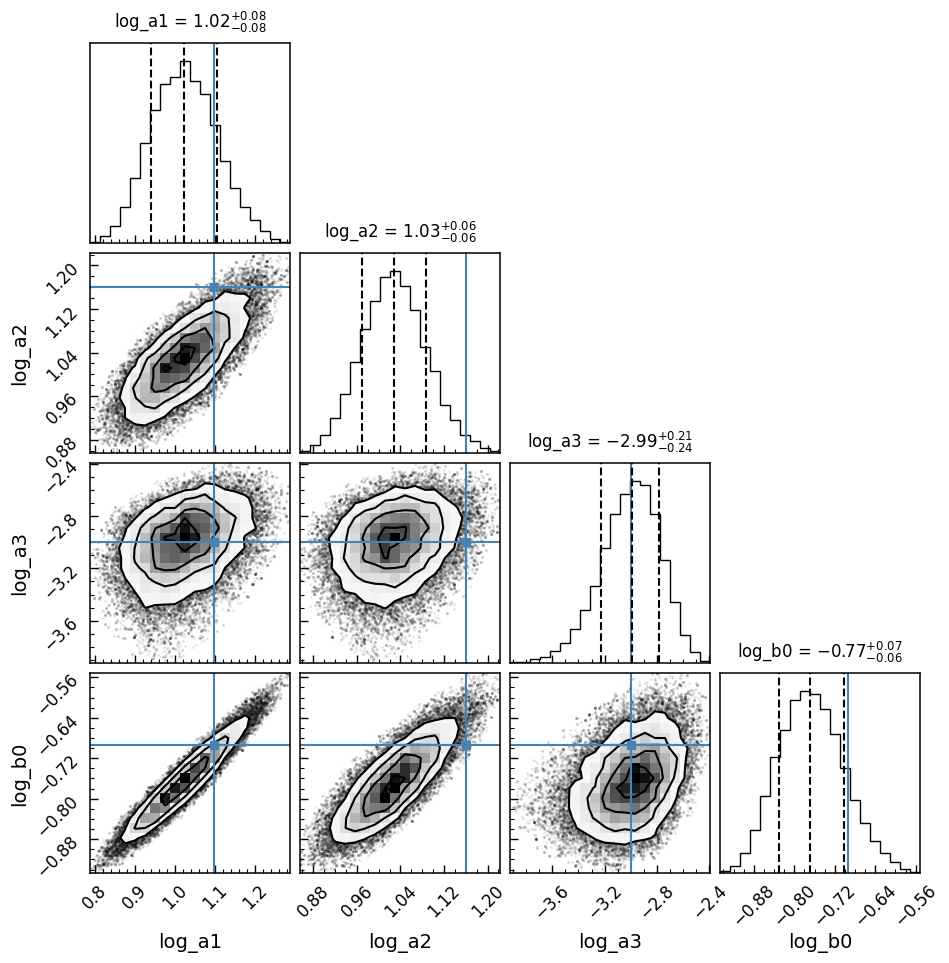

In [18]:
# remove points with low prob for the sake of making good corner plot
prob_threshold = np.percentile(sampler.flatlnprobability, 5)
clean_chain = np.log(carma_params[sampler.flatlnprobability > prob_threshold, :])

# make corner plot
labels = [name.split(':')[1] for name in carma_gp.get_parameter_names()]
corner.corner(clean_chain, truths=carma_kernel.get_parameter_vector(),
              quantiles=[0.16, 0.5, 0.84], labels=labels, show_titles=True,
              title_kwargs={"fontsize": 12});

#### _Final Remark_:
As we have mentioned in previous notebooks, the higher the order of the CARMA models the higher the requirement for the quality of the input time series in order to obtain good inference. In the example above, we used an input time series of S/N = 300, which is very high in a lot of cases. You can use try to change the parameters from the simulation and see how the likelihood landscape would change.